### Notebook which looks at underlying trends which could induce a signal - and hence we should be careful about.
- Plotting $\mathrm{\lambda_R}$ vs Mhalo : 
    - 1) split on stellar mass (Mstel / Mhalo ??) - without *just* filament sample.
    - 2) split on morphology (but overlapping curves on same figure)
    
- Plotting $\mathrm{\lambda_R}$ vs $\epsilon$ : 
    - 1) split on morphology
    - 2) split (or colored) on Mhalo / Mstel
    - 3) split on distance to filament / web classifications

In [357]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kin_morph_funcs as knf
from astropy.cosmology import Planck15
from scipy import interpolate
import scipy.stats as stats
import scipy
import spin_bias_funcs as sbf
import seaborn as sns
import imp
imp.reload(sbf)
from matplotlib import rcParams
sbf.plot_default(rcParams)

In [22]:
# loading in cosmic web catalogues and matching manga ids to get info for all MaNGA targets.
inpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/catalogues/'
outpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/plots/underlying_trends/'

mid = pd.read_csv(inpath+'MaNGA_IDs')
cw = pd.read_csv(inpath+'CW_mpl6_yang_s5.csv')#'CW_SDSS_GC1_S3/DR10_MaNGA_matched_S3.csv')

# merging catalogues and finding manga targets only.
cw_manga_targets = mid.merge(cw, left_on='ID', right_on='ID')

# match to morphology information.
gz = pd.read_csv(inpath+'MaNGA_gz-v1_0_1.csv')
cw_manga_targets_gz = cw_manga_targets.merge(gz, on='MANGAID')

# matching this to my own catalogue because pipe3d don't know what a mangaid is.
mpl8 = pd.read_csv(inpath+'mpl8_main_TNG_ref.csv')
cw_gz_mpl8 = mpl8.merge(cw_manga_targets_gz, left_on='mangaid', right_on='MANGAID')

# matching to angular momentum info.
pipe3d = pd.read_csv(inpath+'manga.Pipe3D_v2_5_3.csv')
cw_gz_pipe3d_mpl8 = cw_gz_mpl8.merge(pipe3d, left_on='plateifu', right_on='plateifu')

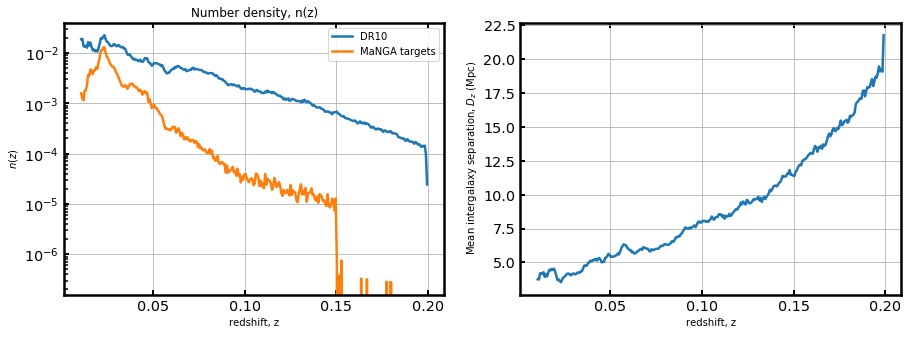

In [3]:
# SDSS DR10 (7966 sq deg) with the redshift limit of z=0.2.
DR10 = fits.open(inpath+'CW_mpl6_yang_s5')[1].data
z_dr10 = DR10['zobs'][(DR10['zobs'] <= 0.2) & (DR10['zobs'] >= 0)]

# Finding redshift range of MaNGA targets only! 
mngtarg_min = min(DR10['zobs'][DR10['ID'] != - 9999])
mngtarg_max = max(DR10['zobs'][DR10['ID'] != - 9999])
# Number of galaxies per redshift bin.
fig,ax = plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
N_z = np.histogram(z_dr10,bins=np.linspace(mngtarg_min,0.2,301))
N_z_manga = np.histogram(DR10['zobs'][DR10['ID'] != - 9999],bins=N_z[1])

#ax[1].plot([np.mean(D_z[:-1]).value,np.mean(D_z[:-1]).value],[0,3500],'k-.')

# Finding the fraction of the sky covered by DR10.
whole_sky_area = 4*np.pi*(180/np.pi)**2 # steradians converted to sq degs.
frac = 7966 / whole_sky_area
# So e.g. volume up to redshift of 0.1
total_vols = frac*Planck15.comoving_volume(N_z[1])
slice_vols = total_vols[1:] - total_vols[:-1]

# So for each redshift slice n = N/V:
number_density = N_z[0] / slice_vols
number_density_manga = N_z_manga[0] / slice_vols

# Now finding the euclidean inter galaxy separation as a function of redshift.
D_z = number_density**(-1/3)

# Finding bin centres
bin_cen = (N_z[1][:-1] + N_z[1][1:])/2
D_z_interpolate = interpolate.interp1d(bin_cen[:-1],D_z[:-1], kind='cubic')
xnew = np.linspace(mngtarg_min,mngtarg_max, num=301, endpoint=True)

ax[0].set_title('Number density, n(z)')
ax[0].plot(bin_cen,number_density.value,label='DR10')
ax[0].plot(bin_cen,number_density_manga.value,label='MaNGA targets')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('redshift, z')
ax[0].set_ylabel(r'$n(z)$')
ax[0].grid()

ax[1].plot(bin_cen[:-1],D_z[:-1],label='Euclidean')
ax[1].set_ylabel(r' Mean intergalaxy separation, $D_z$ (Mpc)')
ax[1].set_xlabel(r'redshift, z')
ax[1].grid()

def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale*0.75, 0.1#ax.get_ylim()[1]*scale

ax[1].annotate('Median = '+str(round(np.median(D_z[:-1]).value,3))+' Mpc\nMean    = '+str(round(np.mean(D_z[:-1]).value,3))+' Mpc', xy=get_axis_limits(ax[1]))
plt.show()

In [23]:
cw_gz_pipe3d_mpl8['log_dskel_norm'] = cw_gz_pipe3d_mpl8.log_dskel.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dwall_norm'] = cw_gz_pipe3d_mpl8.log_dwall.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dnode_norm'] = cw_gz_pipe3d_mpl8.log_dnode.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))


In [321]:
# selecting only mpl8 galaxies.
cw_gz_pipe3d_mpl8_kinpa = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.stel_feature == 0) & (cw_gz_pipe3d_mpl8.halpha_feature == 0) & ((cw_gz_pipe3d_mpl8.stel_qual == 1) | (cw_gz_pipe3d_mpl8.stel_qual == 2)) & ((cw_gz_pipe3d_mpl8.halpha_qual == 1) | (cw_gz_pipe3d_mpl8.halpha_qual == 2))]
# selecting only centrals.
cw_gz_pipe3d_mpl8_cens = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.massive_flag.values == 1) & (cw_gz_pipe3d_mpl8.f_edge.values > 0.6) & (cw_gz_pipe3d_mpl8.halo_mass_stel.values > 0)]

# adding stellar to halo mass ratio. (cens only!)
cw_gz_pipe3d_mpl8_cens['stellar_to_halo_ratio'] = np.log10(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values) -  cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values 

# splitting on morphology.
etgs, S0_Sas, Sb_Sds = knf.morph_breakdown(cw_gz_pipe3d_mpl8_cens)
all_spirals = pd.concat([S0_Sas, Sb_Sds])
all_early = pd.concat([S0_Sas, etgs])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### plotting lambda_r vs epsilon but colored on Mhalo - see if there is any semblance of a trend..

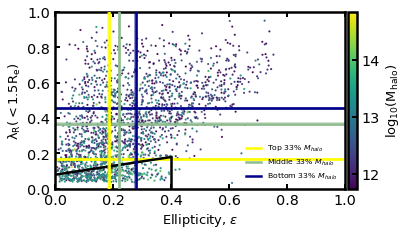

In [38]:
plt.cla()
plt.close('all')
fig = plt.figure(figsize=(5.5,3.25))
ax = fig.add_subplot(111)

# calculating medians for 33 percentiles (since this is how we split the populations).
upper = np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values, 66)
lower = np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values, 33)

# Adding median lines for individual populations.
ax.axvline(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]), linestyle='solid', color='yellow', alpha=1, label=r'Top 33% $M_{halo}$', zorder=5)
ax.axvspan(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           linestyle='solid', color='yellow', alpha=0.3, zorder=5)
ax.axhline(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]), linestyle='solid', color='yellow', alpha=1, zorder=2)
ax.axhspan(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]) - stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]) + stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]), 
           linestyle='solid', color='yellow', alpha=0.3, zorder=2)

mid_mask = (cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values <= upper) & (cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values >= lower)
ax.axvline(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[mid_mask]), linestyle='solid', color='darkseagreen', alpha=1, label=r'Middle 33% $M_{halo}$', zorder=5)
ax.axvspan(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[mid_mask]) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[mid_mask]) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           linestyle='solid', color='darkseagreen', alpha=0.3, zorder=5)
ax.axhline(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]), linestyle='solid', color='darkseagreen', alpha=1, zorder=2)
ax.axhspan(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]) - stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]),
           np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]) + stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]), 
           linestyle='solid', color='darkseagreen', alpha=0.3, zorder=2)

ax.axvline(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < lower]), linestyle='solid', color='darkblue', alpha=1, label=r'Bottom 33% $M_{halo}$', zorder=5)
ax.axvspan(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < lower]) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < lower]) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           linestyle='solid', color='darkblue', alpha=0.3, zorder=5)
ax.axhline(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < lower]), linestyle='solid', color='darkblue', alpha=1, zorder=2)
ax.axhspan(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < lower]) - stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > lower]),
           np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < lower]) + stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > lower]), 
           linestyle='solid', color='darkblue', alpha=0.3, zorder=2)

ax.legend(frameon=False, fontsize=7.75, loc='lower right')

im = ax.scatter(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values, cw_gz_pipe3d_mpl8_cens.lambda_re.values, c=cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values, s=4,  cmap='viridis', edgecolors='grey', linewidth=0.1)
# adding on classically defined SR region 
elp_cond = np.linspace(0,0.4,10)
lam_cond = 0.08 + elp_cond/4
ax.plot(elp_cond,lam_cond,'k')
ax.plot([0.4, 0.4],[0, 0.18],'k')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Ellipticity, $\epsilon$', fontsize=13)
ax.set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=13)

cb = plt.colorbar(im, fraction=0.046, pad=0.01)
cb.set_label(r'$\mathrm{log_{10}(M_{halo})}$', fontsize=13)
plt.savefig(outpath+'lambdaR_epsilon_c-mhalo.pdf', format='pdf', bbox_inches='tight')



#### So centrals that are in higher mass haloes / groups are typically lower angular momentum and are rounder! what a surprise! (I say that as if there hasn't been 3 recent papers on this)

### same again but now colored on stellar mass.

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


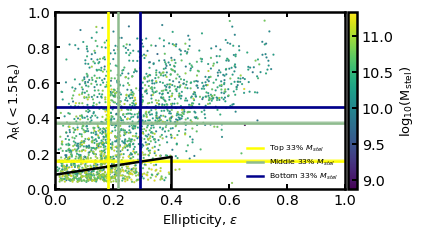

In [57]:
plt.cla()
plt.close('all')
fig = plt.figure(figsize=(5.5,3.25))
ax = fig.add_subplot(111)

# calculating medians for 33 percentiles (since this is how we split the populations).
upper = np.percentile(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values, 66)
lower = np.percentile(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values, 33)

# Adding median lines for individual populations.
ax.axvline(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]), linestyle='solid', color='yellow', alpha=1, label=r'Top 33% $M_{stel}$', zorder=5)
ax.axvspan(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]),
           np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]),
           linestyle='solid', color='yellow', alpha=0.3, zorder=5)
ax.axhline(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]), linestyle='solid', color='yellow', alpha=1, zorder=2)
ax.axhspan(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]) - stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]),
           np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]) + stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]), 
           linestyle='solid', color='yellow', alpha=0.3, zorder=2)

mid_mask = (cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values <= upper) & (cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values >= lower)
ax.axvline(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[mid_mask]), linestyle='solid', color='darkseagreen', alpha=1, label=r'Middle 33% $M_{stel}$', zorder=5)
ax.axvspan(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[mid_mask]) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[mid_mask]) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > upper]),
           linestyle='solid', color='darkseagreen', alpha=0.3, zorder=5)
ax.axhline(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]), linestyle='solid', color='darkseagreen', alpha=1, zorder=2)
ax.axhspan(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]) - stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]),
           np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]) + stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[mid_mask]), 
           linestyle='solid', color='darkseagreen', alpha=0.3, zorder=2)

ax.axvline(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < lower]), linestyle='solid', color='darkblue', alpha=1, label=r'Bottom 33% $M_{stel}$', zorder=5)
ax.axvspan(np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < lower]) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]),
           np.median(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < lower]) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > upper]),
           linestyle='solid', color='darkblue', alpha=0.3, zorder=5)
ax.axhline(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < lower]), linestyle='solid', color='darkblue', alpha=1, zorder=2)
ax.axhspan(np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < lower]) - stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > lower]),
           np.median(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < lower]) + stats.sem(cw_gz_pipe3d_mpl8_cens.lambda_re.values[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > lower]), 
           linestyle='solid', color='darkblue', alpha=0.3, zorder=2)

ax.legend(frameon=False, fontsize=7.75, loc='lower right')

im = ax.scatter(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values, cw_gz_pipe3d_mpl8_cens.lambda_re.values, c=np.log10(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values), s=4,  cmap='viridis', edgecolors='grey', linewidth=0.1)
# adding on classically defined SR region 
elp_cond = np.linspace(0,0.4,10)
lam_cond = 0.08 + elp_cond/4
ax.plot(elp_cond,lam_cond,'k')
ax.plot([0.4, 0.4],[0, 0.18],'k')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Ellipticity, $\epsilon$', fontsize=13)
ax.set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=13)

cb = plt.colorbar(im, fraction=0.046, pad=0.01)
cb.set_label(r'$\mathrm{log_{10}(M_{stel})}$', fontsize=13)
plt.savefig(outpath+'lambdaR_epsilon_c-mstel.pdf', format='pdf', bbox_inches='tight')


### now binning into different cosmic web environments and plotting averages.

In [59]:
# creating ad-hoc function which creates a lambdaR plots for a set of 3 tabs.

def return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax):
    # Adding median lines for individual populations.
    ax.axvline(np.median(1 - filament_tab.nsa_elpetro_ba.values), linestyle='solid', color='darkseagreen', alpha=1, label=r'Filaments', zorder=5)
    ax.axvspan(np.median(1 - filament_tab.nsa_elpetro_ba.values) - stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values),
               np.median(1 - filament_tab.nsa_elpetro_ba.values) + stats.sem(1 - cw_gz_pipe3d_mpl8_cens.nsa_elpetro_ba.values),
               linestyle='solid', color='darkseagreen', alpha=0.3, zorder=5)
    ax.axhline(np.median(filament_tab.lambda_re.values), linestyle='solid', color='darkseagreen', alpha=1, zorder=2)
    ax.axhspan(np.median(filament_tab.lambda_re.values) - stats.sem(filament_tab.lambda_re.values),
               np.median(filament_tab.lambda_re.values) + stats.sem(filament_tab.lambda_re.values), 
               linestyle='solid', color='darkseagreen', alpha=0.3, zorder=2)

    ax.axvline(np.median(1 - node_tab.nsa_elpetro_ba.values), linestyle='solid', color='crimson', alpha=1, label=r'Nodes', zorder=5)
    ax.axvspan(np.median(1 - node_tab.nsa_elpetro_ba.values) - stats.sem(1 - node_tab.nsa_elpetro_ba.values),
               np.median(1 - node_tab.nsa_elpetro_ba.values) + stats.sem(1 - node_tab.nsa_elpetro_ba.values),
               linestyle='solid', color='crimson', alpha=0.3, zorder=5)
    ax.axhline(np.median(node_tab.lambda_re.values), linestyle='solid', color='crimson', alpha=1, zorder=2)
    ax.axhspan(np.median(node_tab.lambda_re.values) - stats.sem(node_tab.lambda_re.values),
               np.median(node_tab.lambda_re.values) + stats.sem(node_tab.lambda_re.values), 
               linestyle='solid', color='crimson', alpha=0.3, zorder=2)

    ax.axvline(np.median(1 - ncw_tab.nsa_elpetro_ba.values), linestyle='solid', color='skyblue', alpha=1, label=r'No CW', zorder=5)
    ax.axvspan(np.median(1 - ncw_tab.nsa_elpetro_ba.values) - stats.sem(1 - ncw_tab.nsa_elpetro_ba.values),
               np.median(1 - ncw_tab.nsa_elpetro_ba.values) + stats.sem(1 - ncw_tab.nsa_elpetro_ba.values),
               linestyle='solid', color='skyblue', alpha=0.3, zorder=5)
    ax.axhline(np.median(ncw_tab.lambda_re.values), linestyle='solid', color='skyblue', alpha=1, zorder=2)
    ax.axhspan(np.median(ncw_tab.lambda_re.values) - stats.sem(ncw_tab.lambda_re.values),
               np.median(ncw_tab.lambda_re.values) + stats.sem(ncw_tab.lambda_re.values), 
               linestyle='solid', color='skyblue', alpha=0.3, zorder=2)

    ax.legend(frameon=False, fontsize=7.75, loc='lower right')

    # adding on classically defined SR region 
    elp_cond = np.linspace(0,0.4,10)
    lam_cond = 0.08 + elp_cond/4
    ax.plot(elp_cond,lam_cond,'k')
    ax.plot([0.4, 0.4],[0, 0.18],'k')

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Ellipticity, $\epsilon$', fontsize=13)
    ax.set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=13)
    return

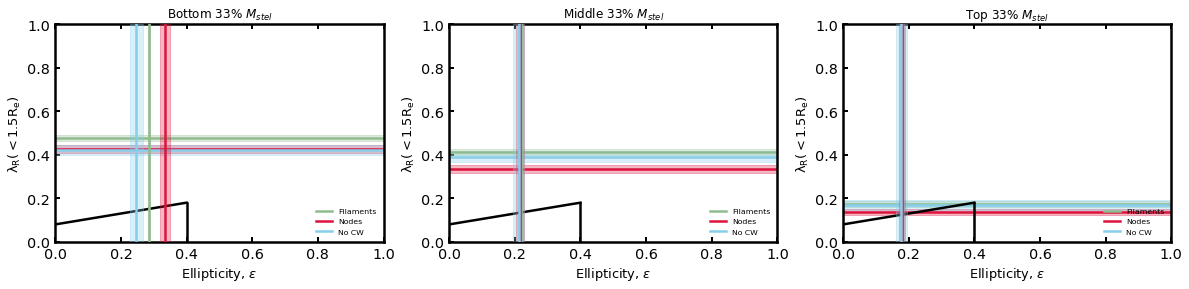

In [83]:
plt.cla()
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(20,4))

# low mass tab.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values < np.percentile(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values , 33)])
return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax[0])
ax[0].set_title('Bottom 33% $M_{stel}$')

# middle mass tab.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens[(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values >= np.percentile(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values , 33)) & (cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values <= np.percentile(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values , 66))])
return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax[1])
ax[1].set_title('Middle 33% $M_{stel}$')

# high mass tab.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens[cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values > np.percentile(cw_gz_pipe3d_mpl8_cens.nsa_elpetro_mass.values , 66)])
return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax[2])
ax[2].set_title('Top 33% $M_{stel}$')
plt.savefig(outpath+'lambdaR_epsilon_grid_skel_s-mstel.pdf', format='pdf', bbox_inches='tight')


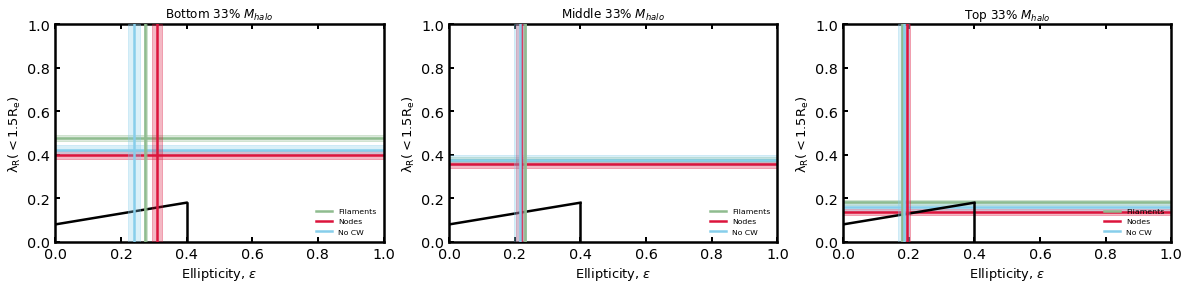

In [85]:
plt.cla()
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(20,4))

# low mass tab.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values < np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values , 33)])
return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax[0])
ax[0].set_title('Bottom 33% $M_{halo}$')

# middle mass tab.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens[(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values >= np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values , 33)) & (cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values <= np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values , 66))])
return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax[1])
ax[1].set_title('Middle 33% $M_{halo}$')

# high mass tab.
filament_tab, _, node_tab, ncw_tab, _ = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens[cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values > np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values , 66)])
return_lambdaR_epsilon(filament_tab, node_tab, ncw_tab, ax[2])
ax[2].set_title('Top 33% $M_{halo}$')
plt.savefig(outpath+'lambdaR_epsilon_grid_skel_s-mhalo.pdf', format='pdf', bbox_inches='tight')

### now creating some lambdaR vs Mhalo plots split on various other params (i.e. not just filament vs control.)
1) split on morphology

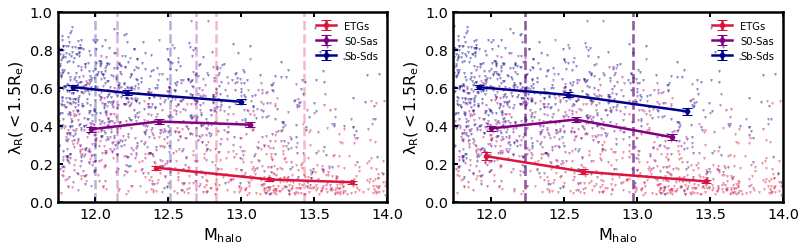

In [387]:
fig, ax = plt.subplots(1,2, figsize=(13, 3.5))

# finding 33 percentiles for individual populations.
sbf.plot_lambdaR_mhalo_single_population(etgs, ax[0], color='crimson', label='ETGs')
sbf.plot_lambdaR_mhalo_single_population(S0_Sas, ax[0], color='purple', label='S0-Sas')
sbf.plot_lambdaR_mhalo_single_population(Sb_Sds, ax[0], color='darkblue', label='Sb-Sds')
ax[0].legend(frameon=False, loc='upper right')

# finding 33 mass percentiles for overall population.
upper = np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values, 66)
lower = np.percentile(cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values, 33)

sbf.plot_lambdaR_mhalo_single_population(etgs, ax[1], color='crimson', lower=lower, upper=upper, label='ETGs')
sbf.plot_lambdaR_mhalo_single_population(S0_Sas, ax[1], color='purple', lower=lower, upper=upper, label='S0-Sas')
sbf.plot_lambdaR_mhalo_single_population(Sb_Sds, ax[1], color='darkblue', lower=lower, upper=upper, label='Sb-Sds')
ax[1].legend(frameon=False, loc='upper right')
plt.savefig(outpath+'lambdaR_mhalo_morphology_split.pdf', format='pdf', bbox_inches='tight')


### 2) split on Mstel / Mhalo

- created agnostic function which splits x vs y plot into x bins and further splits on z.

Text(0.5, 1.0, 'All spirals')

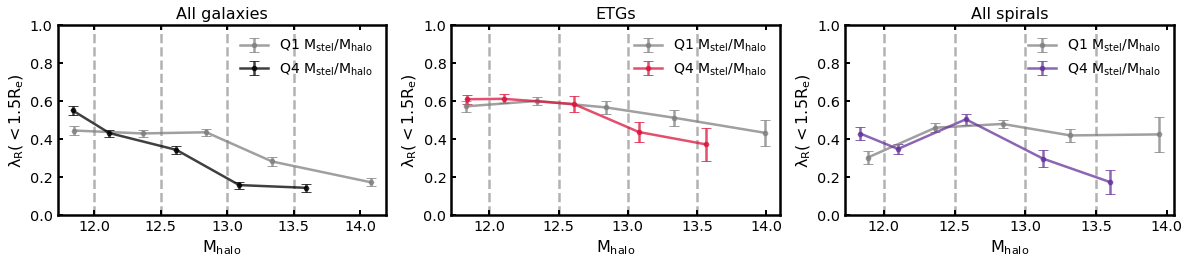

In [393]:
plt.cla()
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(20, 3.5))

## all galaxies.
x_bins = np.array([12, 12.5, 13, 13.5]) 
x_quantity = cw_gz_pipe3d_mpl8_cens.halo_mass_stel.values
z_quantity = cw_gz_pipe3d_mpl8_cens.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = cw_gz_pipe3d_mpl8_cens.lambda_re.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[0], colors=['grey', 'dodgerblue', 'slateblue', 'k'], extrema=True)

for x in x_bins:
    ax[0].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[0].legend(frameon=False, fontsize=14)
ax[0].set_ylim([0, 1])
ax[0].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[0].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[0].set_title('All galaxies', fontsize=16)

## etgs.
x_bins = np.array([12, 12.5, 13, 13.5]) 
x_quantity = etgs.halo_mass_stel.values
z_quantity = etgs.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = etgs.lambda_re.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[1], colors=['grey', 'dodgerblue', 'slateblue', 'crimson'], extrema=True)

for x in x_bins:
    ax[1].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[1].legend(frameon=False, fontsize=14)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[1].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[1].set_title('ETGs', fontsize=16)

## all spirals.
x_bins = np.array([12, 12.5, 13, 13.5]) 
x_quantity = all_spirals.halo_mass_stel.values
z_quantity = all_spirals.stellar_to_halo_ratio.values
z_percentiles = np.array([25, 50, 75])
y_quantity = all_spirals.lambda_re.values

sbf.binned_percentiles_three_props(x_quantity, y_quantity, z_quantity, x_bins, z_percentiles, 
                                   ['Q1 $\mathrm{M_{stel}/M_{halo}}$', 'mid low', 'mid high', 'Q4 $\mathrm{M_{stel}/M_{halo}}$'], 
                                   ax[2], colors=['grey', 'dodgerblue', 'slateblue', 'rebeccapurple'], extrema=True)

for x in x_bins:
    ax[2].axvline(x, color='k', alpha=0.3, linestyle='dashed')

ax[2].legend(frameon=False, fontsize=14)
ax[2].set_ylim([0, 1])
ax[2].set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=16)
ax[2].set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=16)
ax[2].set_title('All spirals', fontsize=16)
plt.savefig(outpath+'lambdaR_mhalo_ratio_all.pdf', format='pdf', bbox_inches='tight ')


In [391]:
10**z_quantity, z_quantity

(array([0.0035821 , 0.01880302, 0.0121993 , ..., 0.01479427, 0.00245076,
        0.01312599]),
 array([-2.44586279, -1.72577231, -1.91366523, ..., -1.82990659,
        -2.61070007, -1.8818678 ]))